In [1]:
import cv2
import numpy as np
from paddleocr import PaddleOCR
import pprint

image_path = "./data/test01.JPG"

ocr_test = PaddleOCR(use_angle_cls=True, lang='korean')
ocr_results  = ocr_test.ocr(image_path)

/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_671227/2818975091.py:8: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr_test = PaddleOCR(use_angle_cls=True, lang='korean')
/home/dibaeck/miniconda3/envs/proj_311/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the

In [2]:
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.equalizeHist(image)
_, binary = cv2.threshold(img, 180, 255, cv2.THRESH_BINARY_INV)         # 이진화 (선명한 선 강조)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))) # 노이즈 제거

# Line Detection
edges = cv2.Canny(binary, 50, 150, apertureSize=3)
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi/180,  # ← 여기 수정
    threshold=50,
    minLineLength=30,
    maxLineGap=5
)

# 블록
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w*h > 500:  # 너무 작은 노이즈 제외
        rects.append((x, y, w, h))


In [3]:
def get_center(poly):
    """텍스트 영역(다각형)의 중심점 계산"""
    pts = np.array(poly)
    cx = np.mean(pts[:, 0])
    cy = np.mean(pts[:, 1])
    return (cx, cy)

def is_inside(rect, point):
    """점(point)이 rect(x, y, w, h) 내부에 있는지 여부"""
    x, y, w, h = rect
    px, py = point
    return (x <= px <= x + w) and (y <= py <= y + h)

In [4]:
mapped_results = []

# PaddleOCR 결과 구조에 따라 처리
rec_texts = ocr_results[0]['rec_texts']
rec_polys = ocr_results[0]['rec_polys']
rec_scores = ocr_results[0]['rec_scores']

for text, poly, score in zip(rec_texts, rec_polys, rec_scores):
    cx, cy = get_center(poly)
    matched_rect = None

    # 중심점이 포함된 블록 탐색
    for rect in rects:
        if is_inside(rect, (cx, cy)):
            matched_rect = rect
            break

    mapped_results.append({
        "text": text,
        "confidence": float(score),
        "center": [float(cx), float(cy)],
        "matched_rect": matched_rect
    })

# ----------------------------
# 6️⃣ 결과 출력
# ----------------------------
pprint.pprint(mapped_results)

print(f"\n총 텍스트 개수: {len(mapped_results)}")
print(f"블록 감지 개수: {len(rects)}")

[{'center': [150.5, 22.0],
  'confidence': 0.9383606910705566,
  'matched_rect': None,
  'text': 'NO.1 SINTER MAIN 전기실'},
 {'center': [262.0, 25.5],
  'confidence': 0.9955829977989197,
  'matched_rect': None,
  'text': '2F'},
 {'center': [793.5, 22.0],
  'confidence': 0.8905296325683594,
  'matched_rect': None,
  'text': '1소결 C열 공정집진기 전기실'},
 {'center': [1324.0, 18.5],
  'confidence': 0.9886642694473267,
  'matched_rect': None,
  'text': 'LOCAL AREA'},
 {'center': [183.25, 85.5],
  'confidence': 0.9908974766731262,
  'matched_rect': (33, 35, 1606, 1114),
  'text': 'H1B1-714-SL02-001'},
 {'center': [364.5, 76.5],
  'confidence': 0.9246314764022827,
  'matched_rect': (33, 35, 1606, 1114),
  'text': 'P-417LV1C–L1,1213,L11A12,L13,'},
 {'center': [393.5, 85.0],
  'confidence': 0.8574122190475464,
  'matched_rect': (33, 35, 1606, 1114),
  'text': '121,122123,31132,L33'},
 {'center': [511.0, 88.5],
  'confidence': 0.9528936743736267,
  'matched_rect': (33, 35, 1606, 1114),
  'text': '417PLC-1

In [5]:
vis_img = image.copy()

# 블록 표시 (녹색)
for rect in rects:
    x, y, w, h = rect
    cv2.rectangle(vis_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# OCR 텍스트 표시 (빨강) + 블록과 연결선 (파랑)
for item in mapped_results:
    cx, cy = map(int, item['center'])
    cv2.putText(vis_img, item['text'], (cx, cy-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
    
    if item['matched_rect'] is not None:
        x, y, w, h = item['matched_rect']
        rect_center = (int(x + w/2), int(y + h/2))
        cv2.line(vis_img, (cx, cy), rect_center, (255, 0, 0), 1)


In [6]:
cv2.imwrite("mapped_output.png", vis_img)

True

/tmp/ipykernel_671227/1958091883.py:10: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(use_angle_cls=True, lang='korean')
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `/home/dibaeck/.paddlex/official_models/PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manua

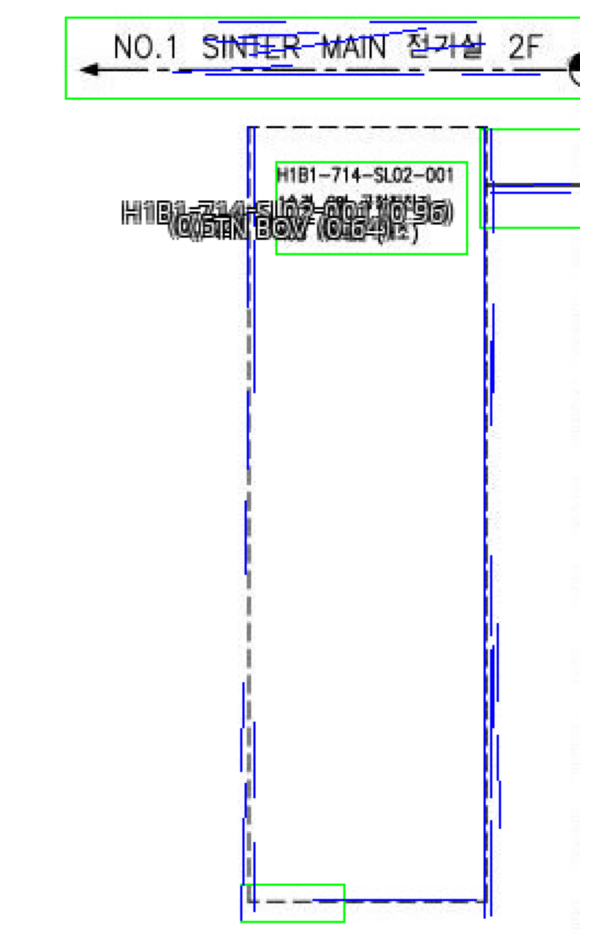

In [10]:
import cv2
import numpy as np
from paddleocr import PaddleOCR
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# ----------------------------
# 1️⃣ OCR 수행
# ----------------------------
ocr = PaddleOCR(use_angle_cls=True, lang='korean')
image_path = './data/test01_re.JPG'
result = ocr.ocr(image_path)

# ----------------------------
# 2️⃣ 원본 이미지 읽기
# ----------------------------
img_color = cv2.imread(image_path)  # 컬러 원본
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# ----------------------------
# 3️⃣ 전처리 (라인/블록 검출용)
# ----------------------------
img_gray = cv2.equalizeHist(img_gray)
_, binary = cv2.threshold(img_gray, 180, 255, cv2.THRESH_BINARY_INV)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))

# ----------------------------
# 4️⃣ Line Detection
# ----------------------------
edges = cv2.Canny(binary, 50, 150, apertureSize=3)
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi/180,
    threshold=50,
    minLineLength=30,
    maxLineGap=5
)

# ----------------------------
# 5️⃣ Block Detection
# ----------------------------
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w * h > 500:
        rects.append((x, y, w, h))

# ----------------------------
# 6️⃣ OCR 텍스트 ↔ 블록 매핑
# ----------------------------
def get_center(poly):
    pts = np.array(poly)
    cx = np.mean(pts[:, 0])
    cy = np.mean(pts[:, 1])
    return (cx, cy)

def is_inside(rect, point):
    x, y, w, h = rect
    px, py = point
    return (x <= px <= x + w) and (y <= py <= y + h)

mapped_results = []
rec_texts = result[0]['rec_texts']
rec_polys = result[0]['rec_polys']
rec_scores = result[0]['rec_scores']

for text, poly, score in zip(rec_texts, rec_polys, rec_scores):
    cx, cy = get_center(poly)
    matched_rect = None
    for rect in rects:
        if is_inside(rect, (cx, cy)):
            matched_rect = rect
            break
    mapped_results.append({
        "text": text,
        "confidence": float(score),
        "center": [float(cx), float(cy)],
        "matched_rect": matched_rect
    })

# ----------------------------
# 7️⃣ PIL 기반 시각화
# ----------------------------
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img_rgb)
draw = ImageDraw.Draw(image)

# 한글 폰트
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
W, H = image.size
font_size = max(12, int(W * 0.015))
thickness = max(1, int(W * 0.002))
font = ImageFont.truetype(font_path, font_size)

# 7-1️⃣ 블록 그리기 (초록)
for rect in rects:
    x, y, w, h = rect
    draw.rectangle([x, y, x + w, y + h], outline=(0, 255, 0), width=thickness)

# 7-2️⃣ 라인 그리기 (파랑)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        draw.line([x1, y1, x2, y2], fill=(0, 0, 255), width=thickness)

# 7-3️⃣ OCR 텍스트 + 연결선
for item in mapped_results:
    cx, cy = map(int, item['center'])
    label = f"{item['text']} ({item['confidence']:.2f})"
    
    # 텍스트 ↔ 블록 연결선
    if item['matched_rect'] is not None:
        x, y, w, h = item['matched_rect']
        rect_center = (int(x + w / 2), int(y + h / 2))
        draw.line([cx, cy, rect_center[0], rect_center[1]], fill=(255, 0, 0), width=thickness)
    
    # 텍스트 외곽선 효과
    outline_color = (0, 0, 0)
    text_color = (255, 255, 255)
    for dx in [-1, 1]:
        for dy in [-1, 1]:
            draw.text((cx + dx, cy - font_size + dy), label, font=font, fill=outline_color)
    draw.text((cx, cy - font_size), label, font=font, fill=text_color)

# ----------------------------
# 8️⃣ 출력
# ----------------------------
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
plt.show()

# 저장
# image.save("mapped_result.png")


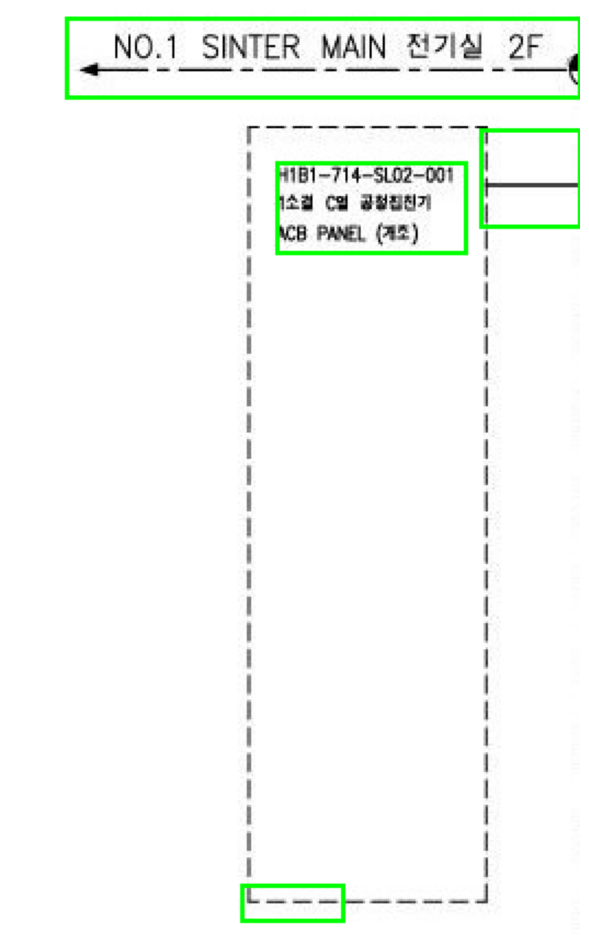

In [11]:
import cv2
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

# 원본 이미지
image_path = './data/test01_re.JPG'
img_color = cv2.imread(image_path)
img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

# 블록 검출용 전처리
img_gray = cv2.equalizeHist(img_gray)
_, binary = cv2.threshold(img_gray, 180, 255, cv2.THRESH_BINARY_INV)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))

# 블록 검출
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if w * h > 500:
        rects.append((x, y, w, h))

# PIL로 시각화
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img_rgb)
draw = ImageDraw.Draw(image)

for rect in rects:
    x, y, w, h = rect
    draw.rectangle([x, y, x + w, y + h], outline=(0, 255, 0), width=2)

# 출력
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
plt.show()


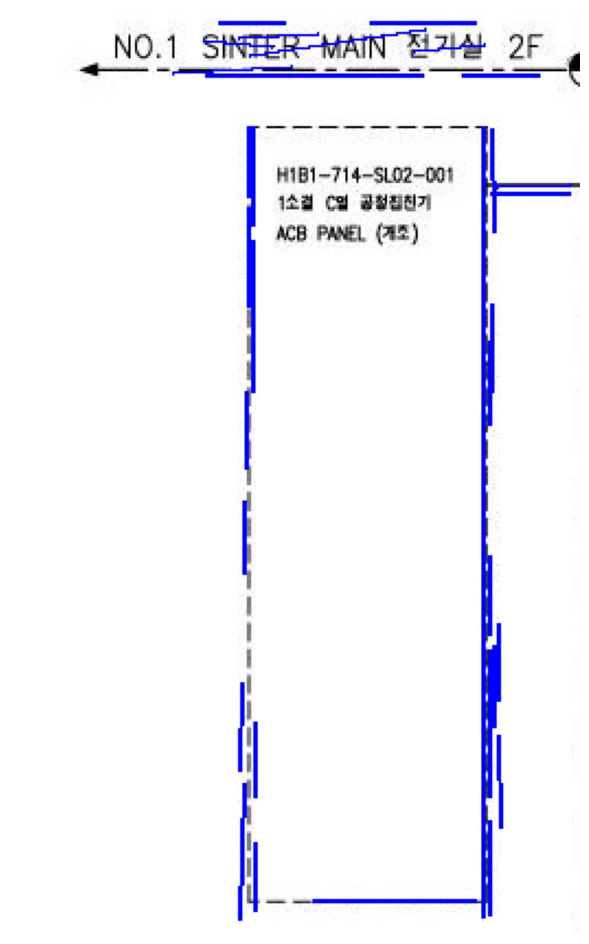

In [12]:
# 라인 검출
edges = cv2.Canny(binary, 50, 150, apertureSize=3)
lines = cv2.HoughLinesP(
    edges,
    rho=1,
    theta=np.pi/180,
    threshold=50,
    minLineLength=30,
    maxLineGap=5
)

# PIL로 시각화
img_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
image = Image.fromarray(img_rgb)
draw = ImageDraw.Draw(image)

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        draw.line([x1, y1, x2, y2], fill=(0, 0, 255), width=2)

# 출력
plt.figure(figsize=(12, 12))
plt.imshow(image)
plt.axis('off')
plt.show()
